In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import networkx as nx
import scipy.stats
from CitNet import Utils
from CitNet import GraphCN
from collections import Counter
from itertools import permutations, combinations
from jyquickhelper import add_notebook_menu

In [30]:
add_notebook_menu()

# Ranking

In [31]:
# Set path to tables
path = os.path.join(os.getcwd(), "Tables")
path_fig = os.path.join(os.getcwd(), "Figures")

In [32]:
# Load data
attrs = pd.read_csv(path + "/attrs_nos.csv", encoding="ISO-8859-1", index_col=0)
auth_coresp = pd.read_csv(path + "/authors.csv", encoding = "ISO-8859-1")
citations_db = pd.concat([pd.read_csv(path + "/cits_edges.csv"),pd.read_csv(path + "/refs_edges.csv")])
hubauth_db = pd.read_csv(path + "/HubsAuths.csv", index_col=0)
cits_edgesdf = pd.read_csv(path + "/cits_edges.csv")
refs_edgesdf = pd.read_csv(path + "/refs_edges.csv")

In [33]:
# Variables, parameters, preprocessing
# Series of Authors ID (potentially multiple authors [id_a1, id_a2], dtype:int)
auths_nos=attrs.authors_nos.copy()
auths_nos=auths_nos.apply(Utils.str_to_list)

# Array of quantiles of interest
ptile = np.concatenate([np.linspace(10, 90, 9, dtype=int),np.linspace(91, 99, 9, dtype=int)])
width = np.concatenate([np.ones(9, dtype=int)*.8, np.ones(9, dtype=int)*.4])

# Names HubAuth_df
hubauth_db = hubauth_db.rename(columns={'xauth_0':'auth_score',
                                        'xhub_0':'hub_score', 
                                        'auth_ranking':'auth_rank', 
                                        'hub_ranking':'hub_rank'})

In [34]:
# Citations processing 
# Agregate numbe of cits/refs by article
Citations=Counter(citations_db.referred_to)
References=Counter(citations_db.referring)
# Dataframe (! index)
cit_df = pd.DataFrame(data=list(Citations.values()), index=Citations.keys(), columns=["in"])
ref_df = pd.DataFrame(data=list(References.values()), index=References.keys(), columns=["out"])
# Add var to attrs
attrs_df=attrs.merge(cit_df, how='outer', left_index=True, right_index=True)
attrs_df=attrs_df.merge(ref_df, how='outer', left_index=True, right_index=True)
# Fill na
attrs_df["in"]=attrs_df["in"].fillna(0).astype(int)
attrs_df["out"]=attrs_df["out"].fillna(0).astype(int)

In [35]:
# Year Processing
attrs_df["year"]=attrs_df.date.str.split("-").str[0].astype(int)

In [36]:
# HubAuths in df
attrs_df = attrs_df.merge(hubauth_db, how='outer', left_index=True, right_index=True)

## Graph


In [37]:
# Converst cits/refs_edgesdf to lists
cits_edges = GraphCN.edgesdf_to_edgeslist(cits_edgesdf)
refs_edges = GraphCN.edgesdf_to_edgeslist(refs_edgesdf)
# Stack refs and cits edges together
all_edges = cits_edges + refs_edges
# Construct nx.DiGraph and adj mat from stacked edges (refs + cits)
cits_refs_graph = nx.DiGraph(all_edges)

In [38]:
# Utils
def dict_rank(dic):
    return {key: rank for rank, key in enumerate(sorted(dic, key=dic.get, reverse=True))}
def dict_to_df(dic, name):
    return pd.DataFrame(data=list(dic.values()), index=dic.keys(), columns=[name])
def dic_to_attrs(dic, name):
    df = dict_to_df(dic, name)
    return attrs_df.merge(df, how='outer', left_index=True, right_index=True)

## Pagerank

In [39]:
# PageRank score
pr_score = nx.pagerank_scipy(cits_refs_graph, alpha=0.85)

In [40]:
# Rank and to attrs
pr_rank = dict_rank(pr_score)
attrs_df = dic_to_attrs(pr_score, "pr_score")
attrs_df = dic_to_attrs(pr_rank, "pr_rank")

## PageRank with Time discount

In [41]:
def t_discount(x, cur_y=2018, tau=3):
    return np.exp(-(cur_y-x)/tau)

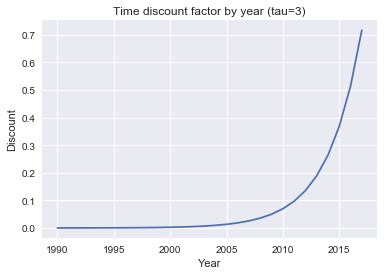

In [42]:
%matplotlib inline
y_lb, y_ub, y, tau = 1990, 2018, 2018, 3
plt.plot(np.arange(y_lb, y_ub), t_discount(np.arange(y_lb, y_ub), y, tau))
plt.xlabel("Year")
plt.ylabel("Discount")
plt.title("Time discount factor by year (tau={0})".format(tau));

In [43]:
# Def time vector
attrs_df["t_disc"] = attrs_df["year"].apply(t_discount)
init_time = dict(attrs_df["t_disc"].loc[cits_refs_graph.nodes()]/\
                 attrs_df["t_disc"].loc[cits_refs_graph.nodes()].sum())

In [44]:
# Get pagerank with init_time
prt_score = nx.pagerank_scipy(cits_refs_graph, alpha=0.85, personalization=init_time)

In [45]:
# Rank and to attrs
prt_rank = dict_rank(prt_score)
attrs_df = dic_to_attrs(prt_score, "prt_score")
attrs_df = dic_to_attrs(prt_rank, "prt_rank")

## Ranks correlation

In [46]:
in_score = dict(attrs_df["in"])
in_rank = dict_rank(in_score)

In [47]:
attrs_df = dic_to_attrs(in_rank, "in_rank")

In [48]:
rank_df = attrs_df[np.isfinite(attrs_df['pr_rank'])].copy()

In [49]:
for i in combinations(['auth_rank', 'pr_rank', 'prt_rank', 'in_rank'], 2):
    j1,j2 = i
    print("Spearman correlation of ({0},{1})".format(j1, j2))
    print(scipy.stats.spearmanr(list(rank_df[j1].dropna().values),
                          list(rank_df[j2].dropna().values)))

Spearman correlation of (auth_rank,pr_rank)
SpearmanrResult(correlation=0.67537251745758109, pvalue=0.0)
Spearman correlation of (auth_rank,prt_rank)
SpearmanrResult(correlation=0.25543950421990902, pvalue=0.0)
Spearman correlation of (auth_rank,in_rank)
SpearmanrResult(correlation=0.81369841888286487, pvalue=0.0)
Spearman correlation of (pr_rank,prt_rank)
SpearmanrResult(correlation=0.29278251304679787, pvalue=0.0)
Spearman correlation of (pr_rank,in_rank)
SpearmanrResult(correlation=0.88907328692817233, pvalue=0.0)
Spearman correlation of (prt_rank,in_rank)
SpearmanrResult(correlation=0.33080278895807719, pvalue=0.0)


**Pairwise Spearman Correlation coefficient**

|        | in_rank | auth_rank | pr_rank | prt_rank |
|:-------|---------|-----------|---------|----------|
| in_rank|         |0.81       |0.88     |0.33      |
| auth_rank|       |           |0.67     |0.25      |
| pr_rank|         |           |         |0.29      |
| prt_rank|        |           |         |          |



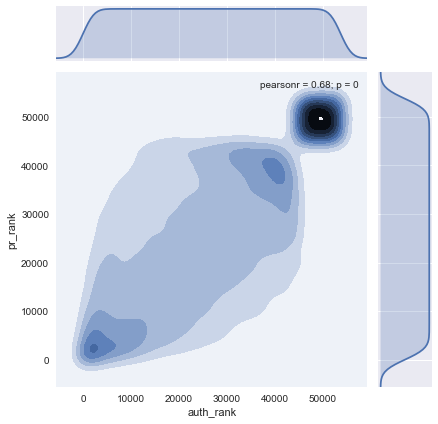

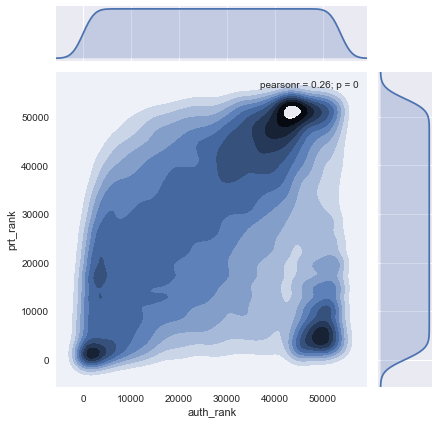

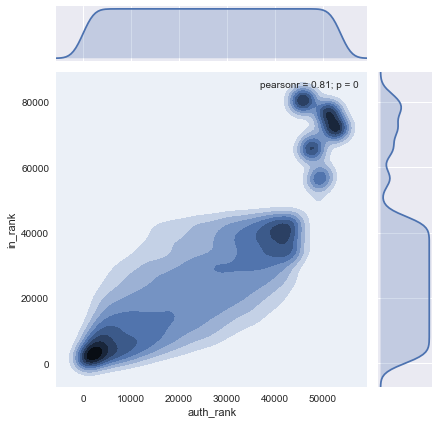

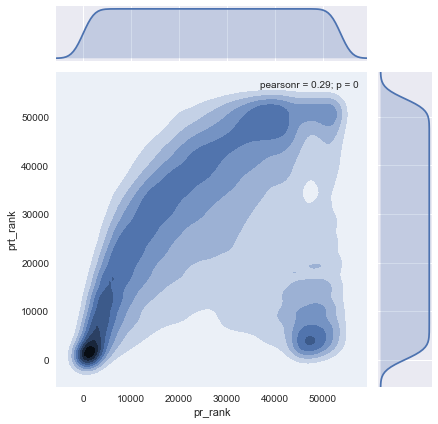

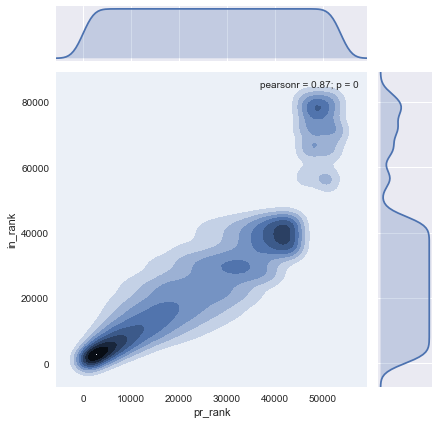

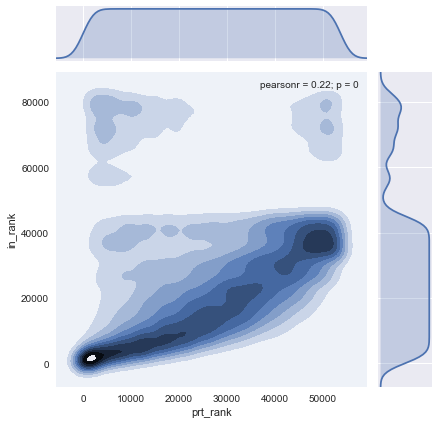

In [50]:
# Join plot
for i in combinations(['auth_rank', 'pr_rank', 'prt_rank', 'in_rank'], 2):
    j1,j2 = i   
    sns.jointplot(j1, j2, rank_df, kind="kde")
    #plt.title("Joint plot of ({0},{1})".format(j1, j2))
    plt.savefig(path_fig + "/jplt_"+j1+"-"+j2+".pdf");

## Time struct 

In [51]:
len(rank_df)

53742

In [52]:
def get_quantile(x, denom=53742):
    return (x*100 // denom)+1

In [53]:
rank_df["in_q"] = rank_df["in_rank"].apply(get_quantile)
rank_df["auth_q"] = rank_df["auth_rank"].apply(get_quantile)
rank_df["pr_q"] = rank_df["pr_rank"].apply(get_quantile) 
rank_df["prt_q"] = rank_df["prt_rank"].apply(get_quantile)

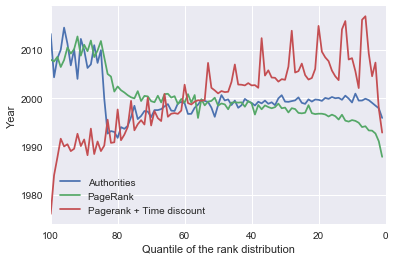

In [54]:
plt.plot(rank_df.groupby("auth_q").mean()["year"], label="Authorities")
plt.plot(rank_df.groupby("pr_q").mean()["year"], label="PageRank")
plt.plot(rank_df.groupby("prt_q").mean()["year"], label="Pagerank + Time discount")
plt.xlim(100,0)
plt.xlabel("Quantile of the rank distribution")
plt.ylabel("Year")
plt.title("")
plt.legend()
plt.savefig(path_fig + "/rank_time.pdf");

## Personalized Pagerank

In [55]:
# 23028 Aghion Howitt
# 23721 Melitz
# 37477 Calvo
# 77112 Bilbiee
# 27752 Piketty

In [56]:
print("Say hello to science!")
query = input()
attrs_df.loc[attrs_df["authors"].str.cat(attrs_df["title"], sep=' ').\
             str.contains(query)==True][["title", "authors","date", "journal"]]

Say hello to science!
27752


,title,authors,date,journal


In [82]:
print("Give me your index")
index = input()
index = int(index)
print("You are looking for {0}".format(attrs_df.loc[index, ["title", "authors","date", "journal"]]))
arg = np.where(np.array(cits_refs_graph.nodes())==index)[0][0]
init_pers = np.zeros(len(cits_refs_graph.nodes()))
np.put(init_pers, [arg], [1])
init_pers = dict(zip(cits_refs_graph.nodes(), init_pers))
pers_score = nx.pagerank_scipy(cits_refs_graph, alpha=1, personalization=init_pers)
pers_rank = dict_rank(pers_score)
print("\n The 30 best results are:")
attrs_df.loc[list(pers_rank.keys())[:30]]

Give me your index
5301
You are looking for title      Endogenous Entry, Product Variety, and Busines...
authors     Florin O. Bilbiie; Fabio Ghironi; Marc J. Melitz
date                                              2012-02-02
journal                                               jpolec
Name: 5301, dtype: object

 The 30 best results are:


,url,title,authors,date,jel_code,keywords,editor,journal,article_id,authors_list,authors_nos,in,out,year,pr_score,pr_rank,t_disc,prt_score,prt_rank
5301,https://ideas.repec.org/a/ucp/jpolec/doi10.108...,"Endogenous Entry, Product Variety, and Busines...",Florin O. Bilbiie; Fabio Ghironi; Marc J. Melitz,2012-02-02,E20; E32,NaN,ucp,jpolec,doi10.1086-665825.html,"['Florin O. Bilbiie', 'Fabio Ghironi', 'Marc J...","[11077, 10688, 23192]",0,29,2012,0.000010,53567.0,0.135335,0.000011,24283.0
12567,https://ideas.repec.org/a/aea/aecrev/v67y1977i...,Monopolistic Competition and Optimum Product D...,"Dixit, Avinash K; Stiglitz, Joseph E",1977-02-02,NaN,NaN,aea,aecrev,v67y1977i3p297-308.html,"['Dixit, Avinash K', 'Stiglitz, Joseph E']","[3211, 19050]",295,0,1977,0.000633,6.0,0.000001,0.000582,12.0
22314,https://ideas.repec.org/a/ecm/emetrp/v50y1982i...,Time to Build and Aggregate Fluctuations,"Kydland, Finn E; Prescott, Edward C",1982-02-02,NaN,NaN,ecm,emetrp,v50y1982i6p1345-70.html,"['Kydland, Finn E', 'Prescott, Edward C']","[11000, 9379]",259,0,1982,0.000367,35.0,0.000006,0.000308,69.0
15433,https://ideas.repec.org/a/aea/aecrev/v82y1992i...,Current Real-Business-Cycle Theories and Aggre...,"Christiano, Lawrence J; Eichenbaum, Martin",1992-02-02,NaN,NaN,aea,aecrev,v82y1992i3p430-50.html,"['Christiano, Lawrence J', 'Eichenbaum, Martin']","[21580, 24199]",105,10,1992,0.000153,287.0,0.000172,0.000136,436.0
10019,https://ideas.repec.org/a/ucp/jpolec/v100y1992...,Oligopolistic Pricing and the Effects of Aggre...,"Rotemberg, Julio J; Woodford, Michael",1992-02-02,NaN,NaN,ucp,jpolec,v100y1992i6p1153-1207.html,"['Rotemberg, Julio J', 'Woodford, Michael']","[19614, 25514]",75,9,1992,0.000125,414.0,0.000172,0.000116,593.0
15604,https://ideas.repec.org/a/aea/aecrev/v83y1993i...,Fiscal Policy in General Equilibrium,"Baxter, Marianne; King, Robert G",1993-02-02,NaN,NaN,aea,aecrev,v83y1993i3p315-34.html,"['Baxter, Marianne', 'King, Robert G']","[23567, 31037]",70,0,1993,0.000088,789.0,0.000240,0.000089,1026.0
9628,https://ideas.repec.org/a/ucp/jpolec/v94y1986i...,Implementation Cycles,"Shleifer, Andrei",1986-02-02,NaN,NaN,ucp,jpolec,v94y1986i6p1163-90.html,"['Shleifer, Andrei']",[1954],24,0,1986,0.000099,625.0,0.000023,0.000065,2134.0
22543,https://ideas.repec.org/a/ecm/emetrp/v53y1985i...,On the Performance of Patents,"Judd, Kenneth L",1985-02-02,NaN,NaN,ecm,emetrp,v53y1985i3p567-85.html,"['Judd, Kenneth L']",[20542],20,0,1985,0.000103,592.0,0.000017,0.000079,1494.0
4624,https://ideas.repec.org/a/oup/qjecon/v117y2002...,An Empirical Characterization of the Dynamic E...,Olivier Blanchard; Roberto Perotti,2002-02-02,E62; E32,NaN,oup,qjecon,v117y2002i4p1329-1368..html,"['Olivier Blanchard', 'Roberto Perotti']","[27303, 31491]",91,13,2002,0.000109,529.0,0.004828,0.000177,244.0
9897,https://ideas.repec.org/a/ucp/jpolec/v98y1990i...,Endogenous Technological Change,"Romer, Paul M",1990-02-02,NaN,NaN,ucp,jpolec,v98y1990i5ps71-102.html,"['Romer, Paul M']",[28232],124,9,1990,0.000204,138.0,0.000088,0.000200,188.0


In [27]:
attrs_df.to_csv(path + "/df_CitNet.csv")